# 06. PyTorch Transfer Learning

What is transfer learning ? 

Transfer learning involves taking the parameters of one model has learned on another dataset and applying them to our own problem.

* Pretrained model = foundation model


In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


Let's import the code we've written in previous section so that we don't need to write it again.

In [2]:
import matplotlib.pyplot as plt 
import torch 
import torchvision 

from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular import data_setup, engine

In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
!nvidia-smi

Sat Jul 19 22:56:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8              4W /   35W |     643MiB /   4096MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

We need pizza, steak, sushi data to build a transfer learning model on.

In [7]:
import os 
import zipfile 
import requests
from pathlib import Path

# Setup data and image path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# Create directory if not already exist
if image_path.is_dir():
    print(f'{image_path} directory exists... skipping re-download')
else:
    print(f'Did not find {image_path}, downloading it..')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print('Downloading pizza, steak, sushi data.....')
        f.write(request.content)

    # Let's extract the data (Unzipping)
    with zipfile.ZipFile(data_path/'pizza_steak_sushi', 'r') as zip_ref:
        print(f'Unzipping pizza, steak, sushi data....')
        zip_ref.extractall(image_path)

    # Remove .zip file 
    os.remove(data_path/'pizza_steak_sushi.zip')
        

data\pizza_steak_sushi directory exists... skipping re-download


In [8]:
# setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data, want to turn it into pytorch dataloaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we create earlier sections.

There's one thing we have to think about when loading data: How to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - You define what transforms you want your data to go through.
2. Automatically created transforms - the transform for you data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

In [9]:
from going_modular import data_setup


### 2.1 Creating a transform for `torchvision.models` (manual creating)

`torchvision.models` contains pretrained models( models ready for transfer learning) right within `torchvision.`

In [11]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]) # imagenet statistics


manual_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize image to 224, 224 (height * width)
    transforms.ToTensor(), # Get images in the range [0, 1]
    normalize # make sure images have the same distribution as imagenet on which our pretrained models are trained on.
])



In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a87d489c90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [14]:
 # Get a set of pretrained model weigths
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT' = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, 
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a87e59bfa0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model 

There are various places to get a pretrained model, such as 
1. PyTorch domain libraries
2. Libraries like 'timm' torch image models
3. HuggingFace Hug (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use? 

**Experiment, experiment, experiment!**

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVisionMini ? )

where does the model live?

Is it on device? (like a self driving car)

Or does it live on a server??

Which model should we choose?/

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best optins in terms of performance vs size.

However, in light of The Bitter lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + mose general we could.

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0.

In [20]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

C:\Users\yashs\anaconda3\envs\torch_gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yashs\anaconda3\envs\torch_gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# New method of creating a pretrained model (torchvision v0.12+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [51]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [52]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [53]:
from torchinfo import summary

In [54]:
# Print summary with torchinfo
summary(model=model,
       input_size=(1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our problem.

With a features extractor model, typically you will 'freeze' the base layer of a pretrained/foundation model and update the output layers to suit your own problem. 

In [55]:
# Freeze all of the base layers in EffNetb0
for param in model.features.parameters():
    param.requires_grad = False
    

In [56]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names)) # how many classes do we have?    
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [57]:
summary(model=model,
       input_size=(1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [58]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
from going_modular import engine

In [60]:
# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=10, 
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.3750 | test_loss: 0.9135 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8831 | train_acc: 0.7422 | test_loss: 0.7950 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7697 | train_acc: 0.8008 | test_loss: 0.7475 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7124 | train_acc: 0.7578 | test_loss: 0.6381 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6283 | train_acc: 0.7812 | test_loss: 0.6271 | test_acc: 0.8759
Epoch: 6 | train_loss: 0.5804 | train_acc: 0.7812 | test_loss: 0.5736 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5332 | train_acc: 0.9180 | test_loss: 0.5451 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5254 | train_acc: 0.8164 | test_loss: 0.5307 | test_acc: 0.8561
Epoch: 9 | train_loss: 0.5639 | train_acc: 0.7930 | test_loss: 0.5084 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4872 | train_acc: 0.8086 | test_loss: 0.4394 | test_acc: 0.9062
[INFO] Total training time: 264.978 seconds


## 5. Evaluate model by plotting loss curves

In [61]:
from helper_functions import plot_loss_curves

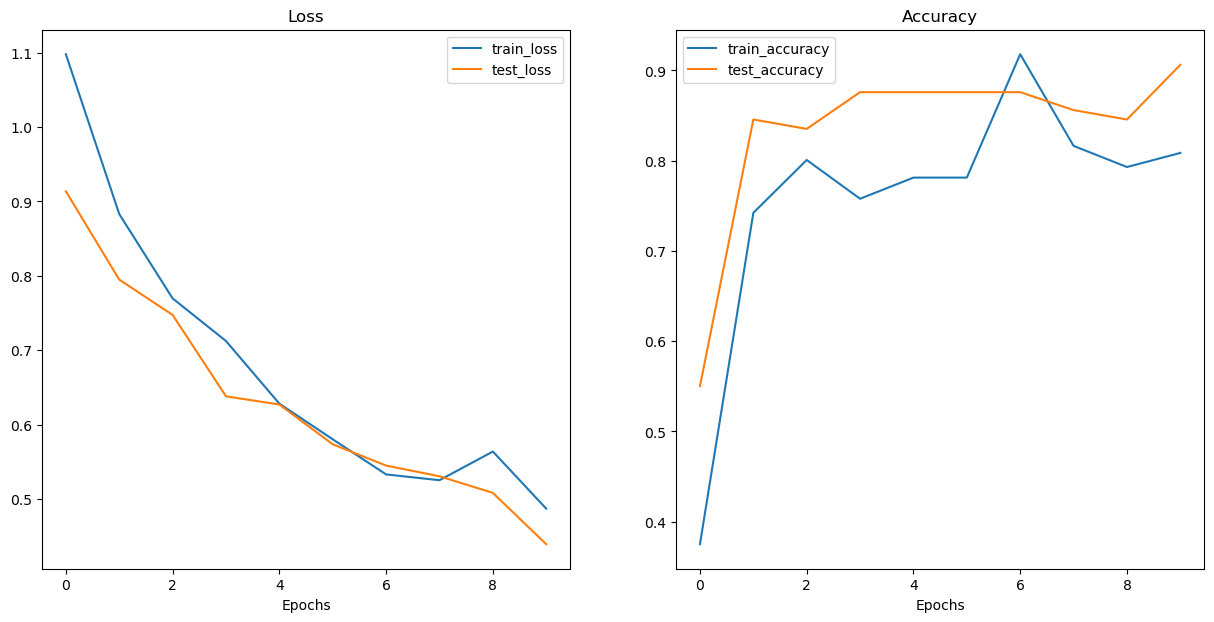

In [63]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set 

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/cusotm data.

We have to make sure that our test/custom data is:
* shape shape - images need to be same shape as model was trained on
* same datatype - custom data should be in the same data type
* same device - custom data / test data should be on the same device as the model
* same transform - if you've tranformed your custom data, ideally you will transform the test data and custom data the same.

To do all of this automatically, let's create a function call `pred_and_plot_image()`.

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference. (this will turn off things like `nn.Dropout`)
6. Transform the target image and make sure it's dimentionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing it to the model.
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probs to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

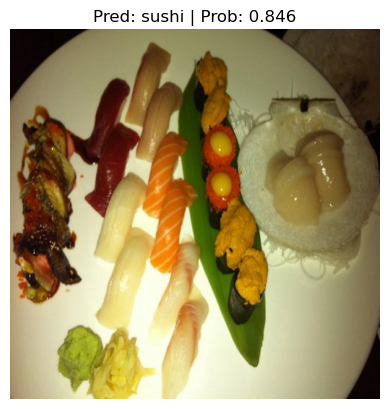

In [95]:
from PIL import Image
from typing import List, Tuple
import numpy as np

# 1. Take in a trained model....
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224 , 224),
                        device: torch.device=device,
                       transform: torchvision.transforms = None
):
    # 2. Open the image with PIL 
    img = Image.open(image_path)

    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            ])

    ### Predict on image ###

    # 4. Make sure the mode is on target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on the transformed image by passing it to the model 
        target_image_pred = model(transformed_image.to(device))

        # 8. Convert the model's output logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # 9. Convert the model's output probs to pred labels
        target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    # Setup the figure
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max().cpu():.3f}')
    plt.axis('off')
pred_and_plot_image(model=model,
                   class_names=class_names,
                   device=device,
                   image_path='data/pizza_steak_sushi/test/sushi/499605.jpg')
    
        
# data/04-pizza-dad.jpeg
    
    

In [96]:
# Get image paths 
image_path

WindowsPath('data/pizza_steak_sushi')

In [97]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

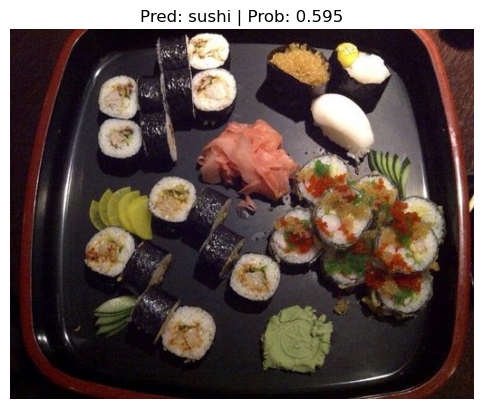

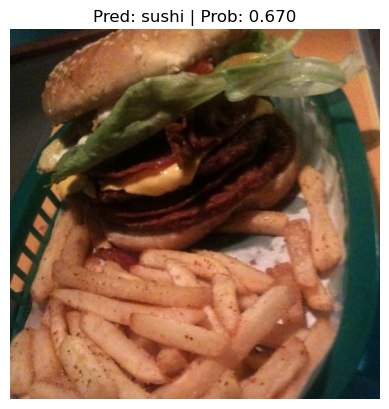

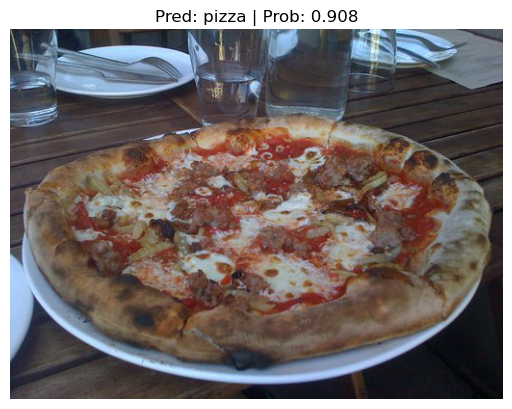

In [98]:
import random
random.seed(42)

random_images = random.sample(image_path_list, k=3)
for image in random_images:
    pred_and_plot_image(model=model,
                   class_names=class_names,
                   device=device,
                   image_path=str(image))
    
    
